In [26]:

import torch.nn.utils.rnn as rnn_utils
import torch.nn as nn
import torch

class SentimentRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.2, activationfn='tanh',):
        super(SentimentRNN, self).__init__()
        
        # RNN layer
        self.rnn = nn.RNN(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True, 
            dropout=dropout, 
            nonlinearity=activationfn, 
            bias=True
            )
    
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    # Inside your model's forward method:
    def forward(self, x, mask, pooling='mean'):
        
        # Pack the padded sequence
        lengths = mask.sum(dim=1).int()  # Compute the lengths of the sequences (number of non-padded elements)
        packed_x = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # Pass through the RNN
        packed_out, hidden = self.rnn(packed_x)
        
        if pooling == 'mean':
        
            # Unpack the sequence
            out, _ = rnn_utils.pad_packed_sequence(packed_out, batch_first=True)
            
            # Perform mean pooling only over the valid (non-padded) parts
            out = (out * mask.unsqueeze(2)).sum(dim=1) / mask.sum(dim=1, keepdim=True)  # Mean pooling
            out = self.fc(out)  # Pass through the fully connected layer
        
        elif pooling == 'max':
            
            # Unpack the sequence to get all hidden states
            out, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
            
            # Pass each hidden state through the fully connected layer to get sentiment scores
            out = self.fc(out).squeeze(-1)  # shape: (batch_size, sequence_length)

            # Perform max pooling over the sentiment scores
            out, _ = torch.max(out, dim=1)  # shape: (batch_size)
            
        elif pooling == 'last':
            # Extract the final hidden state of the last layer
            final_hidden_state = hidden[-1]  # Shape: (batch_size, hidden_size)
            
            # Pass the final hidden state through the fully connected layer
            out = self.fc(final_hidden_state) # Shape: (batch_size, output_size)
        
        else:
            raise ValueError(f"Pooling mode '{pooling}' not supported.")
        
        return out



In [27]:
import gensim.downloader as api
from gensim.models import KeyedVectors

try:
    # Load the model
    word2vec_model = KeyedVectors.load("word2vec.model")
except FileNotFoundError:
    print("Model not found. Downloading it from the internet...")
    pass
    # # Download the model and save it
    # word2vec_model = api.load("word2vec-google-news-300") 
    # word2vec_model.save("word2vec.model")

#Print the shape
print(word2vec_model.vectors.shape)

(3000000, 300)


In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

class SentimentDataset(Dataset):
    def __init__(self, dataset, word2vec_model, max_length=100):
        self.dataset = dataset
        self.word2vec = word2vec_model
        self.max_length = max_length  # Maximum sequence length for padding

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get text and label
        text = self.dataset[idx]['text']
        label = self.dataset[idx]['label']
        
        # Convert text to embeddings
        tokens = text # Assuming text is tokenized already
        embeddings = [self.word2vec[word] for word in tokens if word in self.word2vec]
        
        # Truncate sequences - will pad later
        if len(embeddings) > self.max_length:
            embeddings = embeddings[:self.max_length]
        
        if len(embeddings) == 0:
            return self.__getitem__((idx + 1) % len(self.dataset))  # Skip empty sequences
        
        embeddings = np.array(embeddings)
        
        return torch.tensor(embeddings, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

def collate_fn(batch):
    '''Creates mini-batch tensors from the list of tuples (embeddings, labels, mask).'''
    
    embedding_dim = batch[0][0].size(1)
    
    # Separate embeddings and labels
    embeddings = [item[0] for item in batch]
    labels = [item[1] for item in batch]
        

    # Stack them into tensors
    embeddings = pad_sequence(embeddings, batch_first=True) # (B, L, D)
    
    # Create the mask
    mask = (embeddings.sum(dim=2) != 0).float() # (B, L) - 1 if there is a word, 0 if it's a padding
    
    labels = torch.stack(labels)
    
    return embeddings, labels, mask


In [29]:

from datasets import load_from_disk
import gensim.downloader as api


# This is the training dataset
path_to_train_set = r"../tokenised_datasets/tokenised_train_dataset"
train_dataset = load_from_disk(path_to_train_set)
train_data = SentimentDataset(train_dataset, word2vec_model)
train_loader = DataLoader(train_data, batch_size=48, shuffle=True, collate_fn=collate_fn)

# Get the same for test and validation
path_to_test_set = r"../tokenised_datasets/tokenised_test_dataset"
test_dataset = load_from_disk(path_to_test_set)
test_data = SentimentDataset(test_dataset, word2vec_model)
test_loader = DataLoader(test_data, batch_size=48, shuffle=False, collate_fn=collate_fn)

path_to_val_set = r"../tokenised_datasets/tokenised_validation_dataset"
val_dataset = load_from_disk(path_to_val_set)
val_data = SentimentDataset(val_dataset, word2vec_model)
val_loader = DataLoader(val_data, batch_size=48, shuffle=False, collate_fn=collate_fn)


In [36]:
# Define model parameters
input_size = word2vec_model.vector_size         # Dimension of Word2Vec embeddings
hidden_size = 32        # Number of hidden units
output_size = 1          # Output size (1 for binary classification)
num_layers = 2           # Number of stacked RNN layers
dropout = 0.60        # Dropout rate for regularization
pooling = 'last'        # Use mean pooling


In [37]:
def validate_model(model, val_loader, device, criterion, val_losses=[], val_accuracies=[]):
    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():  # Disable gradient tracking for validation
        for val_embeddings, val_labels, mask in val_loader:
            val_embeddings, val_labels, mask = val_embeddings.to(device), val_labels.to(device), mask.to(device)
            val_outputs = model(val_embeddings, mask).squeeze()
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_labels.size(0)  # Multiply by batch size for total loss
            val_predictions = (torch.sigmoid(val_outputs) >= 0.5).float()  # Threshold at 0.5
            val_correct_predictions += (val_predictions == val_labels).sum().item()
            val_total_samples += val_labels.size(0)

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / val_total_samples
    val_accuracy = val_correct_predictions / val_total_samples
    
    # Store validation metrics for plotting
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    # print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    

Epoch 1/100, Loss: 0.6966, Accuracy: 0.4923 Validation Accuracy: 0.5131
Epoch 2/100, Loss: 0.6899, Accuracy: 0.5348 Validation Accuracy: 0.6032
Epoch 3/100, Loss: 0.6815, Accuracy: 0.5754 Validation Accuracy: 0.6632
Epoch 4/100, Loss: 0.6300, Accuracy: 0.6716 Validation Accuracy: 0.6679
Epoch 5/100, Loss: 0.5734, Accuracy: 0.7130 Validation Accuracy: 0.6895
Epoch 6/100, Loss: 0.5513, Accuracy: 0.7250 Validation Accuracy: 0.6998
Epoch 7/100, Loss: 0.5348, Accuracy: 0.7406 Validation Accuracy: 0.7111
Epoch 8/100, Loss: 0.5233, Accuracy: 0.7456 Validation Accuracy: 0.7129
Epoch 9/100, Loss: 0.5164, Accuracy: 0.7553 Validation Accuracy: 0.7345
Epoch 10/100, Loss: 0.5108, Accuracy: 0.7552 Validation Accuracy: 0.7233
Epoch 11/100, Loss: 0.5036, Accuracy: 0.7611 Validation Accuracy: 0.7326
Epoch 12/100, Loss: 0.4968, Accuracy: 0.7605 Validation Accuracy: 0.7402
Epoch 13/100, Loss: 0.4922, Accuracy: 0.7673 Validation Accuracy: 0.7355
Epoch 14/100, Loss: 0.4895, Accuracy: 0.7669 Validation Accu

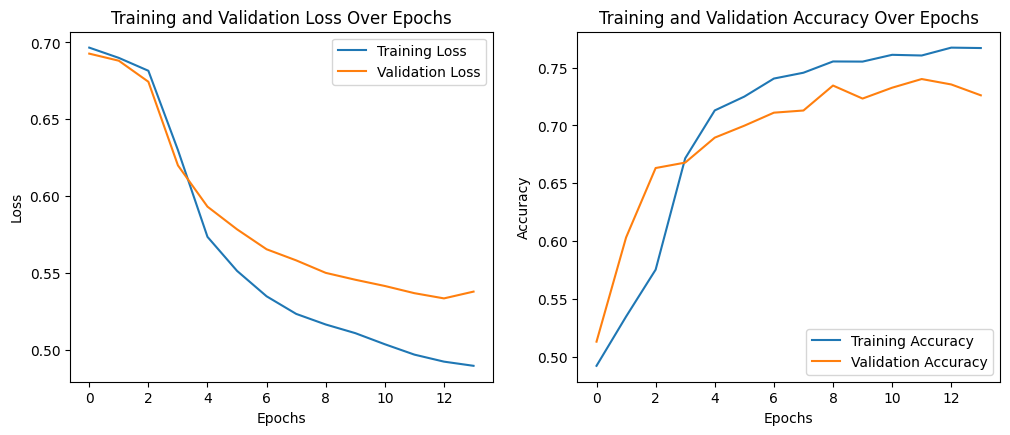

In [38]:
import matplotlib.pyplot as plt
import torch.optim as optim

# Binary Cross-Entropy Loss with Logits
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer with the model's parameters and a learning rate
learning_rate = 0.0001

# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = SentimentRNN(input_size, hidden_size, output_size, num_layers, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)


# Training parameters
num_epochs = 100
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # Set the model to training mode
    model.train()
    for embeddings, labels, mask in train_loader:
        # Move data to the same device as model (GPU if available)
        embeddings, labels, mask = embeddings.to(device), labels.to(device), mask.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(embeddings, mask, pooling).squeeze()
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print the gradients
        # for name, param in model.named_parameters():
        #     print(name, param.grad)
        
        # Accumulate the loss and accuracy
        epoch_loss += loss.item() * labels.size(0)  # Multiply by batch size for total loss
        predictions = (torch.sigmoid(outputs) >= 0.5).float()  # Threshold at 0.5
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / total_samples
    accuracy = correct_predictions / total_samples
    
    # Store metrics for plotting
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}", end=" ")
    validate_model(
        model,
        val_loader,
        device,
        criterion,
        val_losses,
        val_accuracies
    )
    # Early stopping: if the moving average validation accuracy has decreased, then stop
    if epoch > 10 and val_accuracies[-1] < np.mean(val_accuracies[-4:-1]):
        print("Early stopping")
        break 
        
    
# Save the model
torch.save(model.state_dict(), 'sentiment_rnn_2hl_64_055_0006.pth')

# Plot the training and validation loss and accuracy over epochs
plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()

# Plot Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()

plt.show()


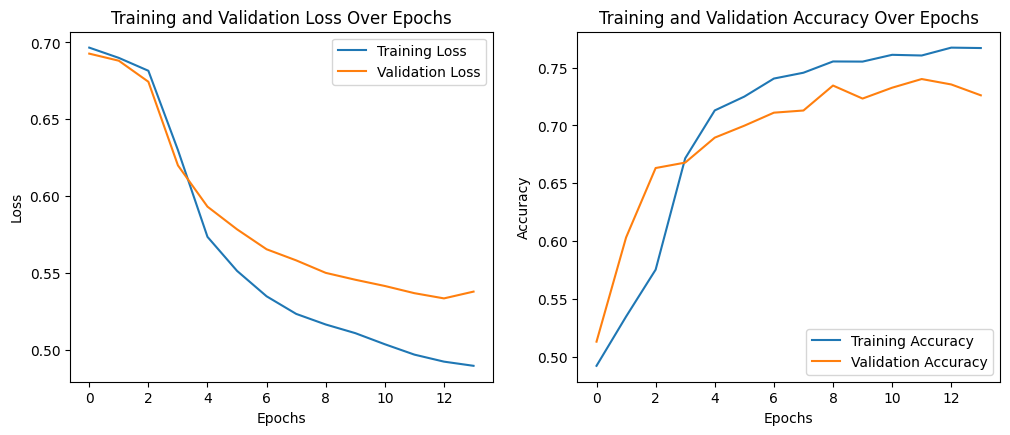

In [39]:
# Plot the training and validation loss and accuracy over epochs
plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()

# Plot Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()

plt.show()


In [40]:
# Save the model
# torch.save(model.state_dict(), 'sentiment_rnn_2hl_196_0003.pth')

#load the model
# model = SentimentRNN(input_size, hidden_size, output_size, num_layers, dropout).to('cuda')
# model.load_state_dict(torch.load('sentiment_rnn_2hl_196_0003.pth'))


In [41]:
from datasets import load_from_disk


# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the validation and test datasets
path_to_val_set = r"../tokenised_datasets/tokenised_validation_dataset"
val_dataset = load_from_disk(path_to_val_set)

path_to_test_set = r"../tokenised_datasets/tokenised_test_dataset"
test_dataset = load_from_disk(path_to_test_set)

# Test the model on the validation set
test_data = SentimentDataset(test_dataset, word2vec_model)
test_loader = DataLoader(test_data, batch_size=48, shuffle=False, collate_fn=collate_fn)

# Set the model to evaluation mode
model.eval()

test_predictions = []
test_targets = []

iteration = 0
for embeddings, labels, mask in test_loader:
    
    print(f"Iteration {iteration + 1}/{len(test_loader)}", end="\r")
    
    
    # Move data to the same device as model
    embeddings, labels, mask = embeddings.to(device), labels.to(device), mask.to(device)
    
    # Forward pass
    outputs = model(embeddings, mask, pooling).squeeze()
    
    # Store the actual and predicted labels
    predictions = (torch.sigmoid(outputs) >= 0.5).float()
    test_predictions.extend(predictions.tolist())
    test_targets.extend(labels.tolist())
    
    print(f"Iteration {iteration + 1}/{len(test_loader)} complete")
    iteration += 1
    
# Calculate the test accuracy
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)
test_accuracy = np.mean(test_predictions == test_targets)

print(f"testidation Accuracy: {test_accuracy:.4f}")

Iteration 1/23 complete
Iteration 2/23 complete
Iteration 3/23 complete
Iteration 4/23 complete
Iteration 5/23 complete
Iteration 6/23 complete
Iteration 7/23 complete
Iteration 8/23 complete
Iteration 9/23 complete
Iteration 10/23 complete
Iteration 11/23 complete
Iteration 12/23 complete
Iteration 13/23 complete
Iteration 14/23 complete
Iteration 15/23 complete
Iteration 16/23 complete
Iteration 17/23 complete
Iteration 18/23 complete
Iteration 19/23 complete
Iteration 20/23 complete
Iteration 21/23 complete
Iteration 22/23 complete
Iteration 23/23 complete
testidation Accuracy: 0.7561
